## Import

In [1]:
# ensure that any edits to libraries you make are reloaded here automatically
%reload_ext autoreload
%autoreload 2

# ensure that any charts or images displayed are shown in this notebook
%matplotlib inline

In [2]:
from google.colab import files
import os

In [3]:
# fastai V1 library which sits on top of Pytorch 1.0
from fastai.vision import *

In [4]:
# to avoid warning of PyTorch
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

## Download dataset from Kaggle

In [ ]:
# ! {sys.executable} -m pip install kaggle --upgrade

To be able to download data from Kaggle you have to provide an API token, which you can find on your Kaggle account. In case of doubt find more information in the following link:

https://github.com/Kaggle/kaggle-api#:~:text=To%20use%20the%20Kaggle%20API,file%20containing%20your%20API%20credentials

In [ ]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
os.listdir()

['.config', 'kaggle.json', 'sample_data']

In [ ]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/

In [ ]:
path = Config.data_path()/'architecture'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/architecture')

In [ ]:
! kaggle datasets download -d wwymak/architecture-dataset

 99% 1.42G/1.43G [00:19<00:00, 93.1MB/s]
100% 1.43G/1.43G [00:19<00:00, 77.1MB/s]


In [ ]:
# bigger dataset
# ! kaggle datasets download -d dumitrux/architectural-styles-dataset

 99% 1.55G/1.56G [00:09<00:00, 157MB/s]
100% 1.56G/1.56G [00:09<00:00, 177MB/s]


In [ ]:
# ! unzip -q -n architectural-styles-dataset.zip -d {path}

In [ ]:
os.listdir()

['.config', 'architectural-styles-dataset.zip', 'sample_data']

In [ ]:
! unzip -q -n architecture-dataset.zip -d {path}

## Looking at the data

We are going to use the Architecture dataset by Zhe Xu, which features 25 architecture styles. Our model will need to learn to differentiate between these 25 distinct categories. According to their paper, the best accuracy they could get in 2014 was nearly 70% accuracy.

In [ ]:
os.listdir('/root/.fastai/data/architecture/arcDataset')

['g-images-dataset', 'architectural-styles-dataset', 'README.txt']

In [ ]:
# bigger dataset
# path = '/root/.fastai/data/architecture/architectural-styles-dataset'

The first thing we do when we approach a problem is to take a look at the data. We always need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

In this particular dataset, labels are stored in the folder name which containt images of each class. We will need to extract them to be able to classify the images into the correct categories. The fastai library has a function made for this, `ImageDataBunch.from_folder`.

In [ ]:
# to not get different results everytime and to be sure that the improvement
# has not been only been chance
np.random.seed(42)

In [ ]:
# transform the data to achive data augmentation, we will see more about this later
tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=10, max_zoom=1.1, 
                      max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75)

In [ ]:
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=tfms, size=224, num_workers=4, padding_mode='reflection', bs=64).normalize(imagenet_stats)

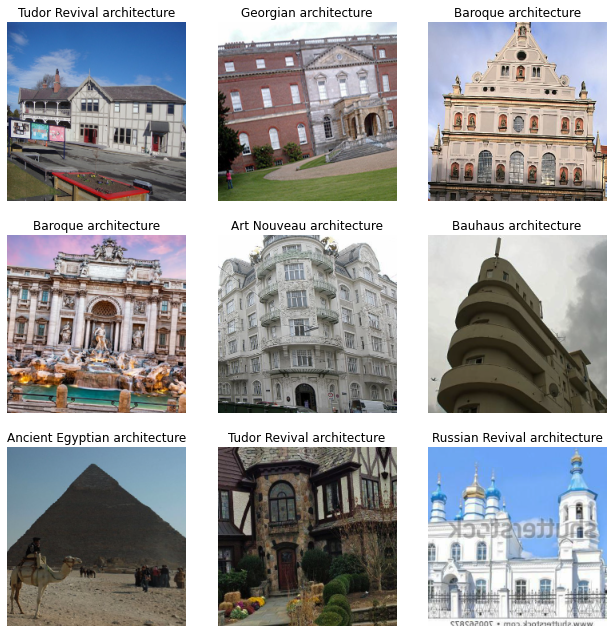

In [ ]:
data.show_batch(rows=3, figsize=(9, 9))

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Achaemenid architecture',
  'American Foursquare architecture',
  'American craftsman style',
  'Ancient Egyptian architecture',
  'Art Deco architecture',
  'Art Nouveau architecture',
  'Baroque architecture',
  'Bauhaus architecture',
  'Beaux-Arts architecture',
  'Byzantine architecture',
  'Chicago school architecture',
  'Colonial architecture',
  'Deconstructivism',
  'Edwardian architecture',
  'Georgian architecture',
  'Gothic architecture',
  'Greek Revival architecture',
  'International style',
  'Novelty architecture',
  'Palladian architecture',
  'Postmodern architecture',
  'Queen Anne architecture',
  'Romanesque architecture',
  'Russian Revival architecture',
  'Tudor Revival architecture'],
 25,
 7671,
 1917)

#### Data augmentation

The `get_transforms` fucntion helped us to get more images to train, in this case we have 9588 images instead of 4979 from the original dataset.

This is achived making some changes to the images and treat them like news images.

Flipping (just horizontal), zooming, light, rotate, etc.

In [ ]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

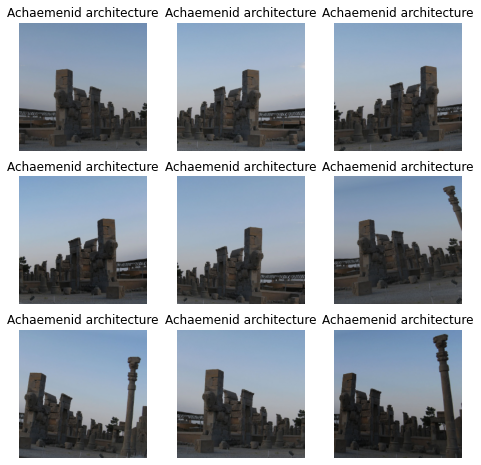

In [ ]:
plot_multi(_plot, 3, 3, figsize=(8,8))

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](https://cs231n.github.io/convolutional-networks/) and a fully connected head with a single hidden layer as a classifier. 
The model that we are building will take images as input and will output the predicted probability for each of the categories (in this case, it will have 25 outputs).

### Training

fit_one_cycle(n) 

n: number of epochs

epochs: looking at every input once. n too big, loot of parameters and high lr maybe overfiting 

Things that can go wrong



*   Learning rate (LR) too high: huge valid_loss
*   Learning rate (LR) too low: valid_loss barerly change during epochs
*   Too few epochs 
*   Too many epochs: valid_loss grows during epochs



In [ ]:
# learn = cnn_learner(data, models.resnet34, metrics=[accuracy, error_rate]).to_fp16()
# float point of 16 bits to make the training faster. It has not worked on this case

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=[accuracy, error_rate])
# doc(cnn_learner)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
# We will train for 4 epochs (4 cycles through all our data)
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.156287,1.082153,0.659364,0.340636,04:46
1,1.333470,0.838536,0.724570,0.275430,04:44
2,0.985724,0.700655,0.763693,0.236307,04:48
3,0.820068,0.650618,0.797079,0.202921,04:50


In [ ]:
learn.save('stage-1-resnet34')

### Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=5)

[('American craftsman style', 'Queen Anne architecture', 12),
 ('Postmodern architecture', 'International style', 11),
 ('Chicago school architecture', 'Art Deco architecture', 10),
 ('International style', 'Postmodern architecture', 9),
 ('Tudor Revival architecture', 'Queen Anne architecture', 9),
 ('Art Deco architecture', 'Art Nouveau architecture', 7),
 ('Beaux-Arts architecture', 'Art Nouveau architecture', 7),
 ('Byzantine architecture', 'Baroque architecture', 7),
 ('International style', 'Art Deco architecture', 7),
 ('Queen Anne architecture', 'American craftsman style', 7),
 ('Edwardian architecture', 'Beaux-Arts architecture', 6),
 ('Palladian architecture', 'Greek Revival architecture', 6),
 ('Postmodern architecture', 'Chicago school architecture', 6),
 ('Queen Anne architecture', 'Greek Revival architecture', 6),
 ('Tudor Revival architecture', 'American craftsman style', 6),
 ('Art Nouveau architecture', 'Beaux-Arts architecture', 5),
 ('Art Nouveau architecture', 'Geor

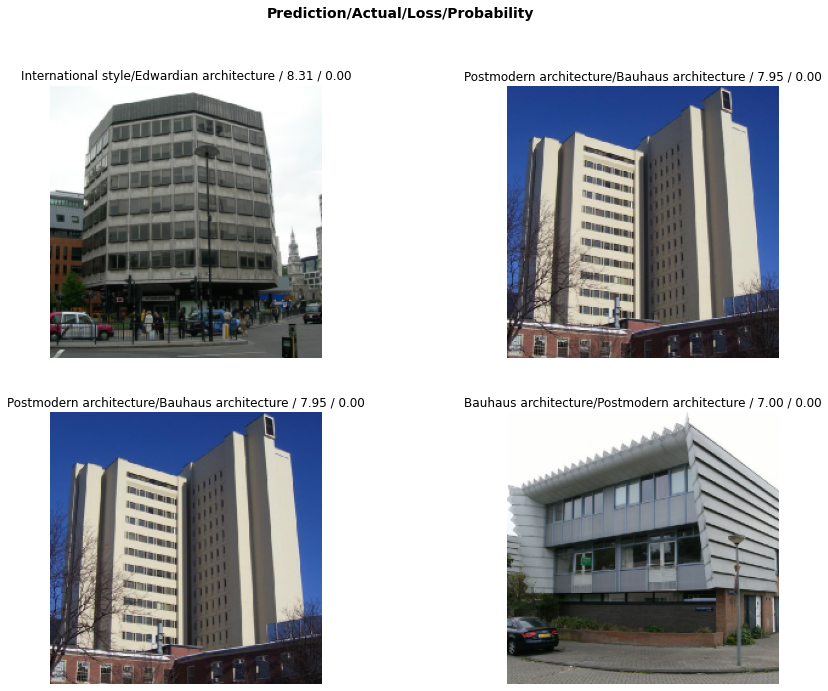

In [ ]:
interp.plot_top_losses(4, figsize=(15,11))

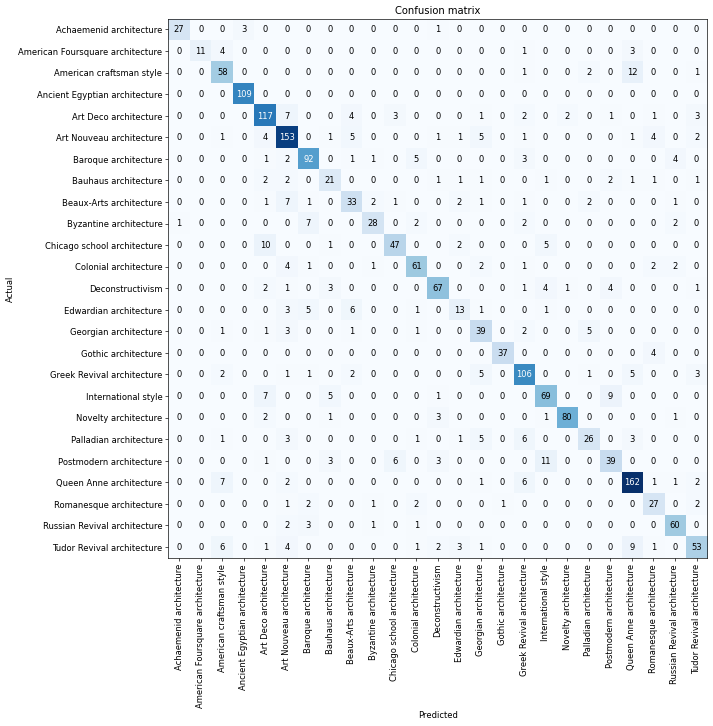

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

### Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will unfreeze our model and train some more.

Single number (1-e3): every layer same lr

Discriminative learning rates, lr for the early layers is smaller, so it will move around less, because we think they are already good. Good for transfer learning.

Discriminative learning rates:
*   Single number to slice slice(1-e3) final layers get that lr. The other layers get the that lr/3
*   In this case slice(1-e5,1-e3), the last layers will have 1-e3, the first layer will get 1-e5 and the rest layers equally spread number between this two



In [ ]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


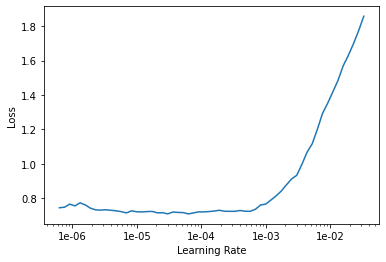

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.732617,0.565627,0.818466,0.181534,05:00
1,0.557574,0.429622,0.868545,0.131455,05:01
2,0.442947,0.364829,0.886281,0.113719,05:02
3,0.390729,0.353376,0.889411,0.110589,05:01


In [ ]:
learn.save('stage-2-resnet34')

In [ ]:
os.listdir('/root/.fastai/data/architecture/models')

['tmp.pth',
 'stage-1-resnet50-fp16.pth',
 'stage-2-resnet34-slice1.pth',
 'stage-2-resnet34-slice2.pth',
 'stage-1-resnet34.pth']

In [ ]:
# learn = learn.load('stage-1-resnet34')

In [ ]:
# learn.export()
# smaller size in case if no big differencce between resnet34 and resnet50

## Training: resnet50

Now we will train in the same way as before but instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's use larger images too, since that way the network can see more detail.

### Training

In [ ]:
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=tfms, size=299, num_workers=4, padding_mode='reflection', bs=64).normalize(imagenet_stats)

wd: weight decay
To avoid overfitting and still using a big amont of parameters. To make te function less complex, 

In [ ]:
# learn = cnn_learner(data, models.resnet50, metrics=[accuracy, error_rate], wd=1e-1).to_fp16()
# there is no impovement with fp16

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy, error_rate], wd=1e-1)

In [ ]:
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.813591,0.964684,0.707877,0.292123,05:16
1,1.143414,0.753339,0.761607,0.238393,05:13
2,0.799008,0.565517,0.821075,0.178925,05:17
3,0.591807,0.443042,0.860720,0.139280,05:15
4,0.442781,0.376208,0.883151,0.116849,05:14
5,0.348192,0.364300,0.885759,0.114241,05:14


In [ ]:
learn.save('stage-1-resnet50-6cycles')

### Unfreezing, fine-tuning and learning rates

In [ ]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


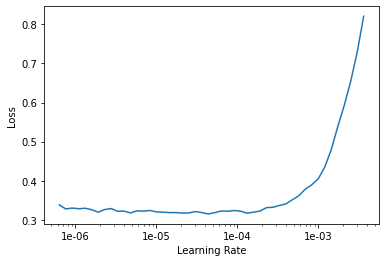

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(6, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.307224,0.331769,0.900887,0.099113,05:18
1,0.270905,0.253635,0.923839,0.076161,05:18
2,0.196671,0.211835,0.933751,0.066249,05:23
3,0.143010,0.179330,0.948878,0.051122,05:22
4,0.105811,0.175410,0.949400,0.050600,05:23
5,0.091795,0.171961,0.952530,0.047470,05:33


In [ ]:
learn.save('stage-2-resnet50', return_path=True)

### Results resnet50

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=3)

[('International style', 'Postmodern architecture', 7),
 ('International style', 'Art Deco architecture', 4),
 ('Tudor Revival architecture', 'American craftsman style', 4),
 ('American Foursquare architecture', 'American craftsman style', 3),
 ('Baroque architecture', 'Romanesque architecture', 3)]

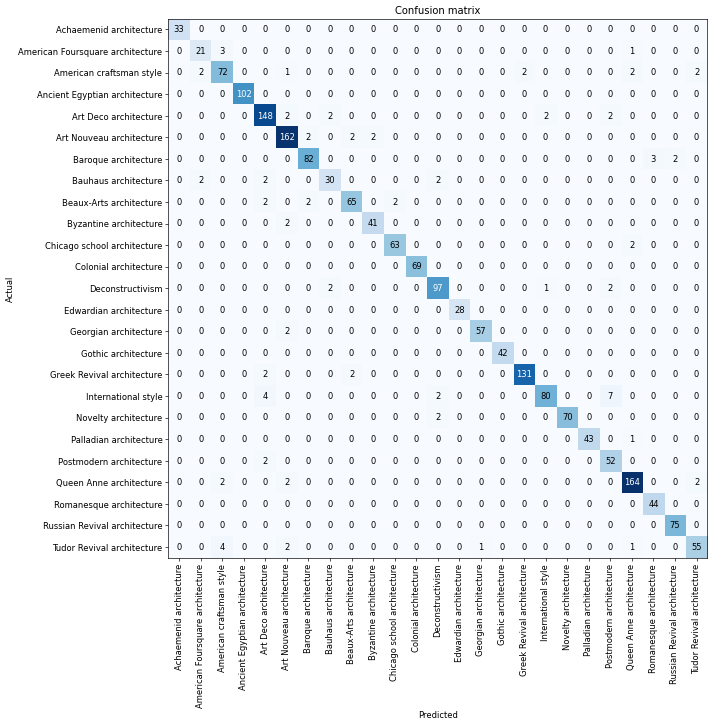

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Duplicate images on top losses, because of data augmentation

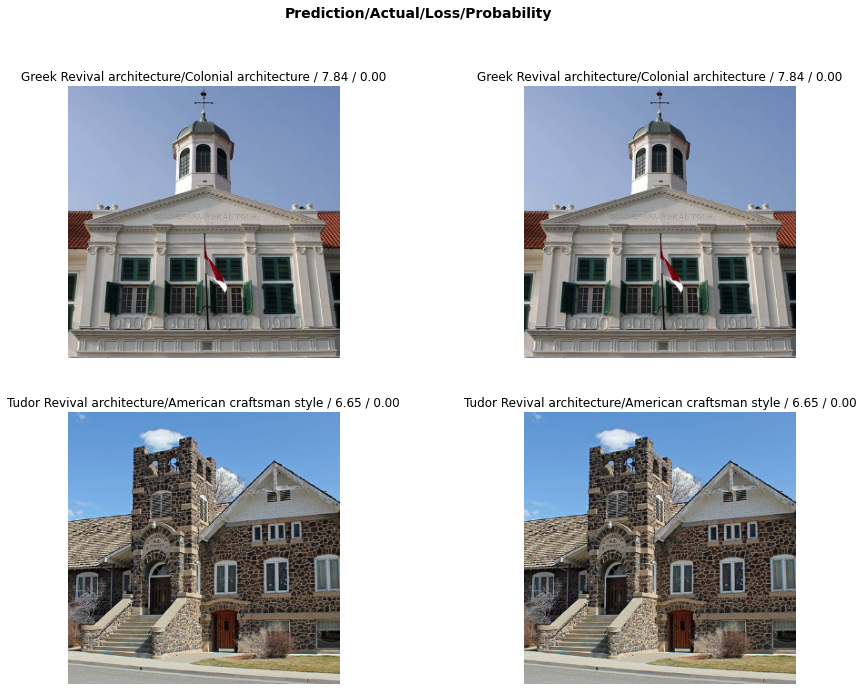

In [ ]:
interp.plot_top_losses(4, figsize=(15,11))

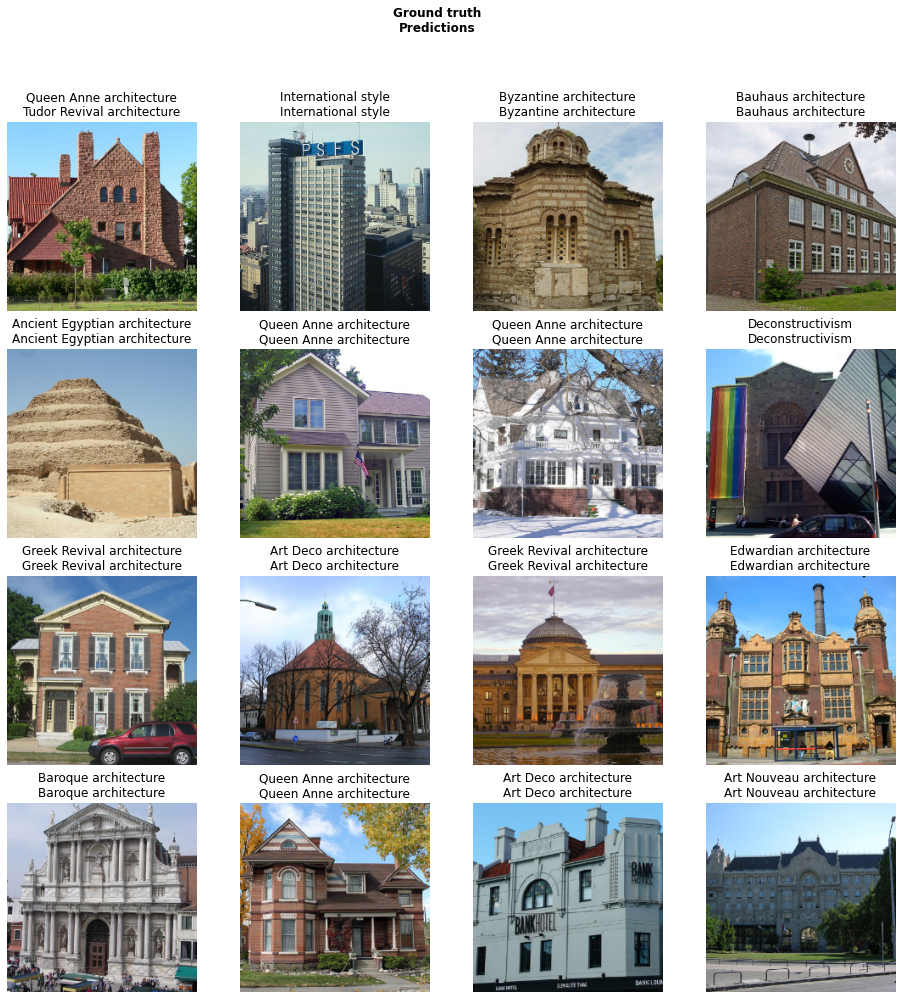

In [ ]:
learn.show_results(rows=4)

In [ ]:
img = open_image(path/'arcDataset'/'Bauhaus architecture'/'46_800px-Friedrichshafen_Hafenbahnhof_Zeppelinmuseum.jpg')
# img

In [ ]:
pred_class,pred_idx,outputs = learn.predict(img)
data.classes[int(pred_class)]

'Art Deco architecture'

In [ ]:
outputs

tensor([4.8131e-05, 4.0115e-04, 1.5859e-04, 1.8332e-05, 9.1667e-01, 2.8412e-04,
        6.4029e-06, 1.6311e-02, 1.4279e-04, 2.3726e-05, 3.7191e-04, 4.3844e-05,
        2.8516e-03, 1.0721e-04, 1.3770e-05, 5.1941e-05, 4.0738e-05, 6.0796e-02,
        2.3134e-04, 1.5984e-06, 1.3584e-03, 1.8242e-06, 2.2416e-05, 4.1732e-05,
        5.2506e-06])

## Putting model in production

### Download model

Only the parameters are saved, not the actual architecture (so you'll need to create your model in the same way before loading weights back in)

In [ ]:
os.listdir('/root/.fastai/data/architecture/models')

['299-resnet50.pth',
 's1-101.pth',
 's2.3-101.pth',
 's2-101.pth',
 'tmp.pth',
 's2.2-101.pth',
 '101.pth']

In [ ]:
cp /root/.fastai/data/architecture/models/299-resnet50.pth .

In [ ]:
os.listdir()

['.config',
 'validation_test_2',
 '299-resnet50.pth',
 'architecture-dataset.zip',
 'sample_data']

### Download to deploy model

To put model in production, export the minimal state of your Learner.
This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

In [ ]:
learn.export()

In [ ]:
#from google.colab import files
#files.download('/root/.fastai/data/architecture/export.pkl') 
!cp /root/.fastai/data/architecture/export.pkl .

In [ ]:
# !rm /root/.fastai/data/architecture/export.pkl

In [ ]:
# path of export.pkl
os.listdir('/root/.fastai/data/architecture')

['export.pkl', 'arcdataset', 'arcDataset', 'models']

We create our `Learner` in production enviromnent like this, just make sure that `path` contains the file 'export.pkl' from before.

In [ ]:
img = open_image(path/'black'/'00000021.jpg')
# img

In [ ]:
learn = load_learner(path)

In [ ]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class.obj

## Scrapping from google to valid dataset and valid test with google images

#### Upload model

In [ ]:
uploaded = files.upload()

Saving stage-2-resnet50.pth to stage-2-resnet50.pth


In [ ]:
np.random.seed(42)
tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=10, max_zoom=1.1, 
                      max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75)

data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=tfms, size=224, num_workers=4, padding_mode='reflection').normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy, error_rate], wd=1e-1)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
os.mkdir('/root/.fastai/data/architecture/models')

In [ ]:
models_dir = '/root/.fastai/data/architecture/models/'
os.rename('stage-2-resnet50.pth', models_dir + 'stage-2-resnet50.pth')

In [ ]:
learn = learn.load('stage-2-resnet50')

### Download images from google

In [ ]:
from imutils import paths
import argparse
import requests
import cv2

In [ ]:
data.classes, data.c

(['Achaemenid architecture',
  'American Foursquare architecture',
  'American craftsman style',
  'Ancient Egyptian architecture',
  'Art Deco architecture',
  'Art Nouveau architecture',
  'Baroque architecture',
  'Bauhaus architecture',
  'Beaux-Arts architecture',
  'Byzantine architecture',
  'Chicago school architecture',
  'Colonial architecture',
  'Deconstructivism',
  'Edwardian architecture',
  'Georgian architecture',
  'Gothic architecture',
  'Greek Revival architecture',
  'International style',
  'Novelty architecture',
  'Palladian architecture',
  'Postmodern architecture',
  'Queen Anne architecture',
  'Romanesque architecture',
  'Russian Revival architecture',
  'Tudor Revival architecture'],
 25)

In [ ]:
os.mkdir("validation_test_2");

In [ ]:
os.chdir('validation_test_2')

In [ ]:
# Upload 25 files with from 47 to 49 urls of images of each architecture style
uploaded = files.upload()

Saving Achaemenid architecture.txt to Achaemenid architecture.txt
Saving American craftsman style.txt to American craftsman style.txt
Saving American Foursquare architecture.txt to American Foursquare architecture.txt
Saving Ancient Egyptian architecture.txt to Ancient Egyptian architecture.txt
Saving Art Deco architecture.txt to Art Deco architecture.txt
Saving Art Nouveau architecture.txt to Art Nouveau architecture.txt
Saving Baroque architecture.txt to Baroque architecture.txt
Saving Bauhaus architecture.txt to Bauhaus architecture.txt
Saving Beaux-Arts architecture.txt to Beaux-Arts architecture.txt
Saving Byzantine architecture.txt to Byzantine architecture.txt
Saving Chicago school architecture.txt to Chicago school architecture.txt
Saving Colonial architecture.txt to Colonial architecture.txt
Saving Deconstructivism.txt to Deconstructivism.txt
Saving Edwardian architecture.txt to Edwardian architecture.txt
Saving Georgian architecture.txt to Georgian architecture.txt
Saving Got

In [ ]:
os.listdir()

['Achaemenid architecture',
 'Bauhaus architecture',
 'Romanesque architecture',
 'Art Nouveau architecture',
 'Russian Revival architecture',
 'Georgian architecture',
 'Queen Anne architecture',
 'Gothic architecture',
 'Novelty architecture',
 'Postmodern architecture',
 'International style',
 'Deconstructivism',
 'Ancient Egyptian architecture',
 'Baroque architecture',
 'Chicago school architecture',
 'American craftsman style',
 'Tudor Revival architecture',
 'Edwardian architecture',
 'American Foursquare architecture',
 'Byzantine architecture',
 'Colonial architecture',
 'Art Deco architecture',
 'Palladian architecture',
 'Greek Revival architecture',
 'Beaux-Arts architecture']

In [ ]:
os.getcwd()

'/content/validation_test_2'

In [ ]:
rows = {}

for filename in os.listdir():
  if filename.endswith(".txt"): 
    rows[filename] = open(filename).read().strip().split("\n")

len(rows)

25

In [ ]:
# import shutil
# shutil.rmtree('Queen Anne architecture')

Now you will need to download your images from their respective urls.

In [ ]:
num_images = 0
progress = 0
folders = data.c
validation_test_2 = {}

for arch_type in rows:
  os.mkdir(arch_type[:-4])
  os.rename(arch_type, arch_type[:-4] + '/' + arch_type)
  for url in rows[arch_type]:
    try:
      r = requests.get(url, timeout=60)
      # save the image to disk
      p = os.path.sep.join([arch_type[:-4], "{}.jpg".format(str(num_images).zfill(6))])
      f = open(p, "wb")
      f.write(r.content)
      f.close()
      num_images += 1
      
    except:
      print("[INFO] error downloading {}...skipping".format(p))

  progress += 1
  txt = "Progress: {} / {}"
  print(txt.format(progress, folders))
  validation_test_2[arch_type] = len(rows[arch_type])

num_images

Progress: 1 / 25
Progress: 2 / 25
Progress: 3 / 25
[INFO] error downloading American craftsman style/000192.jpg...skipping
Progress: 4 / 25
Progress: 5 / 25
Progress: 6 / 25
Progress: 7 / 25
Progress: 8 / 25
Progress: 9 / 25
Progress: 10 / 25
Progress: 11 / 25
Progress: 12 / 25
Progress: 13 / 25
Progress: 14 / 25
[INFO] error downloading Palladian architecture/000693.jpg...skipping
Progress: 15 / 25
[INFO] error downloading Chicago school architecture/000748.jpg...skipping
Progress: 16 / 25
[INFO] error downloading Baroque architecture/000795.jpg...skipping
Progress: 17 / 25
Progress: 18 / 25
Progress: 19 / 25
Progress: 20 / 25
Progress: 21 / 25
Progress: 22 / 25
Progress: 23 / 25
Progress: 24 / 25
Progress: 25 / 25


1204

Then we can remove any images that can't be opened

In [ ]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

#### View data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    num_img = ""
    if (i < 10):
      num_img = "0" + str(i)
    else: 
      num_img = str(i)

    img = cv2.imread("Palladian architecture/0000" + num_img + ".jpg")
    img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_cvt)
plt.show()

# ?open_image it is from fastai
# img = open_image('validation_test_2/00000047.jpg')
# img

### Prdiction of google images

predictions:

*   [0]: folder === architecture style
*   [1]: pred_class (result)
*   [2]: pred_idx
*   [3]: outputs (percentatges)
*   [4]: error (1:error, 0:no error)
*   [5]: no valid image (1:no valid, 0:valid)



In [ ]:
img_analyzed = 0
predictions = [[0 for x in range(6)] for y in range(num_images)]
errors = 0
progress = 0
folders = data.c

for folder in os.listdir():
  for file in os.listdir(folder):
    try:
      if file.endswith(".jpg"):
        img = open_image(folder + '/' + file)
        pred_class,pred_idx,outputs = learn.predict(img)

        num_img = int(file[:-4])
        predictions[num_img][0] = folder
        predictions[num_img][1] = pred_class
        predictions[num_img][2] = pred_idx
        predictions[num_img][3] = outputs
        predictions[num_img][5] = 0

        if (folder != data.classes[int(pred_class)]):
          errors += 1
          predictions[num_img][4] = 1
        
        img_analyzed += 1

    except:
      print("ERROR ON: " + folder + " : " + file)


  progress += 1
  txt = "Progress: {} / {}"
  print(txt.format(progress, folders))


err_rate = errors/img_analyzed

ERROR ON: Achaemenid architecture : 000862.jpg
ERROR ON: Achaemenid architecture : 000855.jpg
Progress: 1 / 25
ERROR ON: Bauhaus architecture : 000273.jpg
Progress: 2 / 25
Progress: 3 / 25
ERROR ON: Art Nouveau architecture : 000939.jpg
ERROR ON: Art Nouveau architecture : 000937.jpg
Progress: 4 / 25
ERROR ON: Russian Revival architecture : 000604.jpg
Progress: 5 / 25
ERROR ON: Georgian architecture : 001037.jpg
ERROR ON: Georgian architecture : 001052.jpg
ERROR ON: Georgian architecture : 001012.jpg
Progress: 6 / 25
ERROR ON: Queen Anne architecture : 000362.jpg
ERROR ON: Queen Anne architecture : 000352.jpg
ERROR ON: Queen Anne architecture : 000377.jpg
ERROR ON: Queen Anne architecture : 000339.jpg
ERROR ON: Queen Anne architecture : 000375.jpg
ERROR ON: Queen Anne architecture : 000366.jpg
Progress: 7 / 25
ERROR ON: Gothic architecture : 001137.jpg
Progress: 8 / 25
ERROR ON: Novelty architecture : 001202.jpg
ERROR ON: Novelty architecture : 001191.jpg
Progress: 9 / 25
ERROR ON: Pos

In [ ]:
# resnet50, size 299, bs 64, 6/6
# 299
print(errors)
err_rate

563


0.4925634295713036

### Cleaning up

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

In [ ]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import clear_output

Populating the interactive namespace from numpy and matplotlib


In [ ]:
errors_i = 0
for i in range(len(predictions)):
  if predictions[i][4] == 1:
    errors_i += 1
    txt = "Progress: {} / {}"
    print(txt.format(errors_i, errors))
    print(predictions[i][0] + '\n' + data.classes[int(predictions[i][1])])

    filename = str(i).zfill(6) + '.jpg'
    img=mpimg.imread(predictions[i][0] + '/' + filename)
    imgplot = plt.imshow(img)
    plt.show()
    
    time.sleep(3)
    clear_output(wait=True)

In [ ]:
errors2 = 0
num_not_valid = 0
# folder_mal = {"nada"}

print("Not Valid? 1:No Valid, 0: Valid")

for i in range(len(predictions)):
  txt = "Progress: {} / {}"
  print(txt.format(i, len(predictions)))

  if predictions[i][4] == 1:
    filename = str(i).zfill(6) + '.jpg'
    print(predictions[i][0] + '/' + data.classes[int(predictions[i][1])])
    img=mpimg.imread(predictions[i][0] + '/' + filename)
    imgplot = plt.imshow(img)
    plt.show()
    not_valid = input()
    
    if not_valid == 1:
      predictions[i][5] = 1
      num_not_valid += 1
    else:
      errors2 += 1
    clear_output(wait=True)
    # folder_mal.add(predictions[i][0])

num_not_valid
# len(folder_mal)

## Useful Commands

In [ ]:
# Check GPU specifications
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5047182343072051235, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 418186798096987602
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3704858690032314173
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1481506816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7059847821871815234
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [ ]:
# Check CPU and RAM specifications
!cat /proc/cpuinfo
!cat /proc/meminfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2200.000
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4400.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

In [ ]:
# Cloning a git repository
!git clone [git clone url]

In [ ]:
# Download from the web to colab disk (temporal)
!wget 'https://images-na.ssl-images-amazon.com/images/I/91GG851w5EL.jpg'

In [ ]:
# Download from the web to your Drive
!wget [url] -p drive/[Folder Name]

In [ ]:
# https://medium.com/lean-in-women-in-tech-india/google-colab-the-beginners-guide-5ad3b417dfa
# Mounting Google Drive
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# Click on the link and enter the api key.

In [ ]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [ ]:
# Your drive is now mounted. You can use any files and folders in your drive by using the path as follows
!ls /content/drive/[folder name]